In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import joblib
from interpret.glassbox import ExplainableBoostingRegressor
from igann import IGANNRegressor
from igann import IGANN
from sklearn.base import BaseEstimator, RegressorMixin
from torch.nn import ReLU, ELU
from sklearn.model_selection import TimeSeriesSplit



with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load (f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load (f)
with open('test_y_df.pkl', 'rb') as f:
    test_y_df = pickle.load (f)
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load (f)
with open('diff_info.pkl', 'rb') as f:
    diff_info = pickle.load(f)

"""train_diff_order = diff_info['train_diff_order']
train_y_diff_order = diff_info['train_y_diff_order']
train_startwerte = diff_info['train_startwerte']
train_y_startwert = diff_info['train_y_startwert']"""

min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

X = train_df
y = train_y_df


## IGANN

### mit IGANNRegressor (Test)
aber kein plot_single

In [8]:
selected_features = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Oil Spot Price (Brent)', 'S-Coal Price (close)_rollmean_3', 'N-Demand non-LDZ_lag30', 'Season_Summer', 'N-Demand LDZ_rollstd_30', 'S-Coal Price (close)_rollstd_3']

# Train- und Test-Daten vorbereiten, nur mit den ausgewählten Features
X_train = train_df[selected_features]
y_train = train_y_df
X_test = test_df[selected_features]

tscv = TimeSeriesSplit(n_splits=3)
# IGANN-Modell
igann_model = IGANNRegressor(
    n_estimators=30,
    n_hid=10,
    boost_rate=0.1,
    init_reg=1.0,
    elm_scale=0.1,
    elm_alpha=1.0,
    act='relu',
    early_stopping=10,
    device='cpu',
    random_state=42,
    verbose=0
)

# Hyperparameter-Grid für GridSearch
param_grid_igann = {
    'boost_rate': [ 0.01, 0.05, 0.1],            # Sehr kleine Lernraten für glattere Anpassung
    'n_estimators': [150, 200],             # Genügend ELMs für stabile Ergebnisse
    'n_hid': [10, 20],                      # Nicht zu komplex, aber ausreichend
    'init_reg': [0.1, 0.5],                # Moderat für eine balancierte Startphase
    'elm_scale': [0.5, 1],                # Kleine Skalen = ruhigere Transformationen
    'elm_alpha': [0.001, 0.01],             # Leichte Regularisierung zur Glättung
    'early_stopping': [10, 15],             # Frühes Stoppen bei keiner Verbesserung

}

# GridSearchCV für Hyperparameteroptimierung
grid_search = GridSearchCV(
    igann_model,
    param_grid_igann,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# GridSearch ausführen
grid_search.fit(X_train, y_train)

# Beste Hyperparameter
print(f"\nBeste Hyperparameter: {grid_search.best_params_}")

# Beste Modellvorhersage
best_igann_regressor = grid_search.best_estimator_
y_pred = best_igann_regressor.predict(X_test)

# Rückskalierung der Vorhersagen
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
mae_raw = mean_absolute_error(test_y_df, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

print(f"MAE (rescaled): {mae:.4f}")
print(f"RMSE (rescaled): {rmse:.4f}")
print(f"R² (rescaled): {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Echte Werte', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='Vorhersage (IGANN)', linestyle='--', color='blue')
plt.title('IGANN-Vorhersage mit GridSearch')
plt.xlabel('Zeit')
plt.ylabel('Gaspreis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 192 candidates, totalling 576 fits


KeyboardInterrupt: 

### mit IGANN (task = 'regression')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
MAE (rescaled): 27.9472
RMSE (rescaled): 32.4117
R² (rescaled): -26.7006


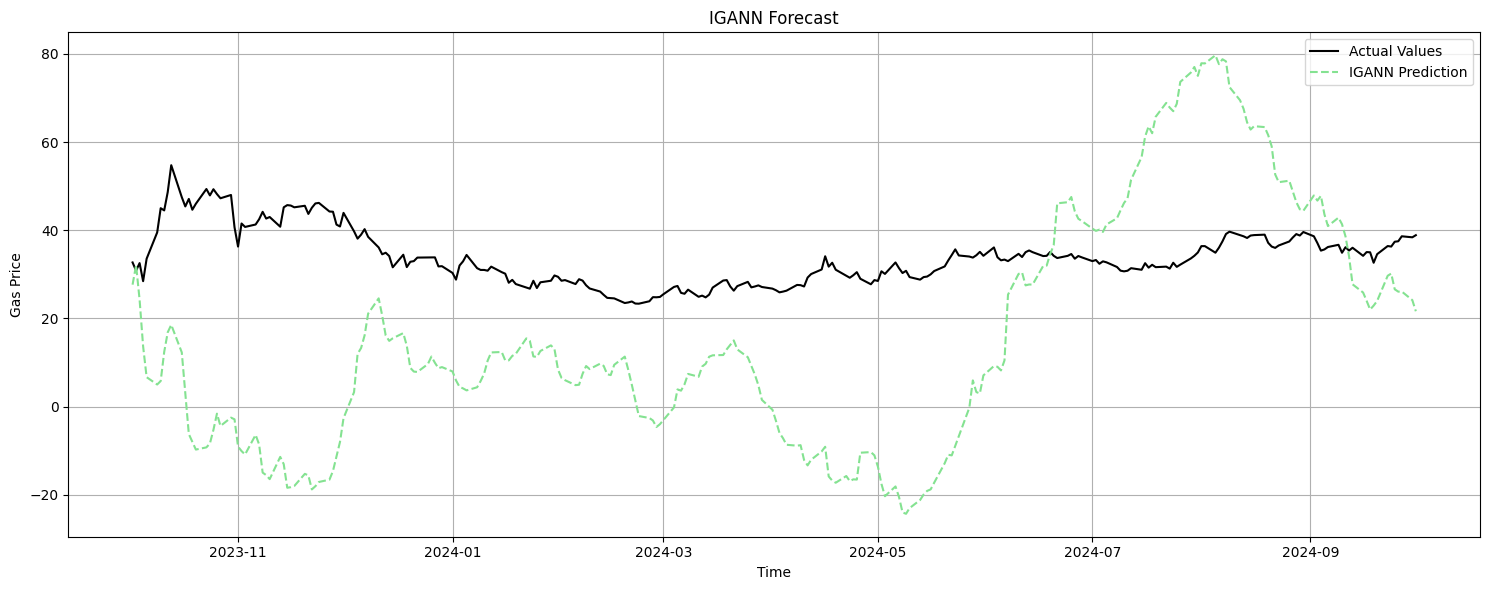

In [ ]:
selected_features = ['N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

# Train- und Test-Daten vorbereiten
X_train = train_df[selected_features]
y_train = train_y_df
X_test = test_df[selected_features]

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# IGANN-Modell
igann_model = IGANN(task = 'regression', device='cpu', random_state=42, verbose=0)

# Angepasstes Grid
param_grid_igann = {
    'boost_rate': [0.025, 0.1],
    'elm_scale': [1, 2, 5]
}

grid_search = GridSearchCV(
    igann_model,
    param_grid_igann,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Beste Hyperparameter und Vorhersage
best_igann = grid_search.best_estimator_
y_pred = best_igann.predict(X_test)

# Rückskalierung
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

print(f"MAE (rescaled): {mae:.4f}")
print(f"RMSE (rescaled): {rmse:.4f}")
print(f"R² (rescaled): {r2:.4f}")
print(f"\nBeste Hyperparameter: {grid_search.best_params_}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='IGANN Prediction', linestyle='--', color='#84E291')
plt.title('IGANN Forecast')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



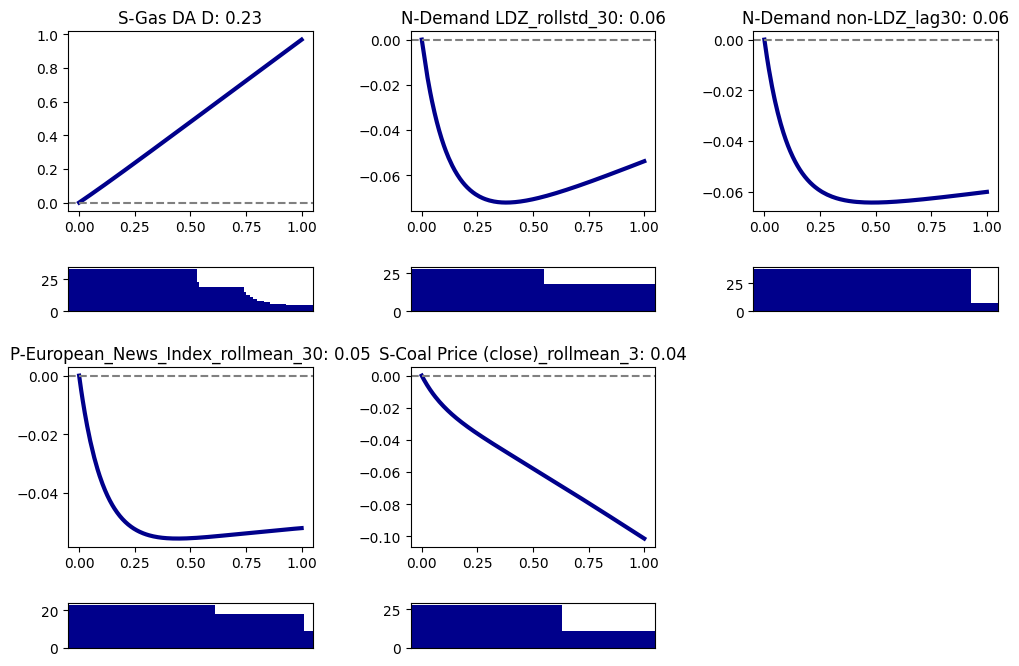

In [9]:
best_igann.plot_single()

### untuned

MAE (rescaled): 27.0971
RMSE (rescaled): 31.3627
R² (rescaled): -24.9366


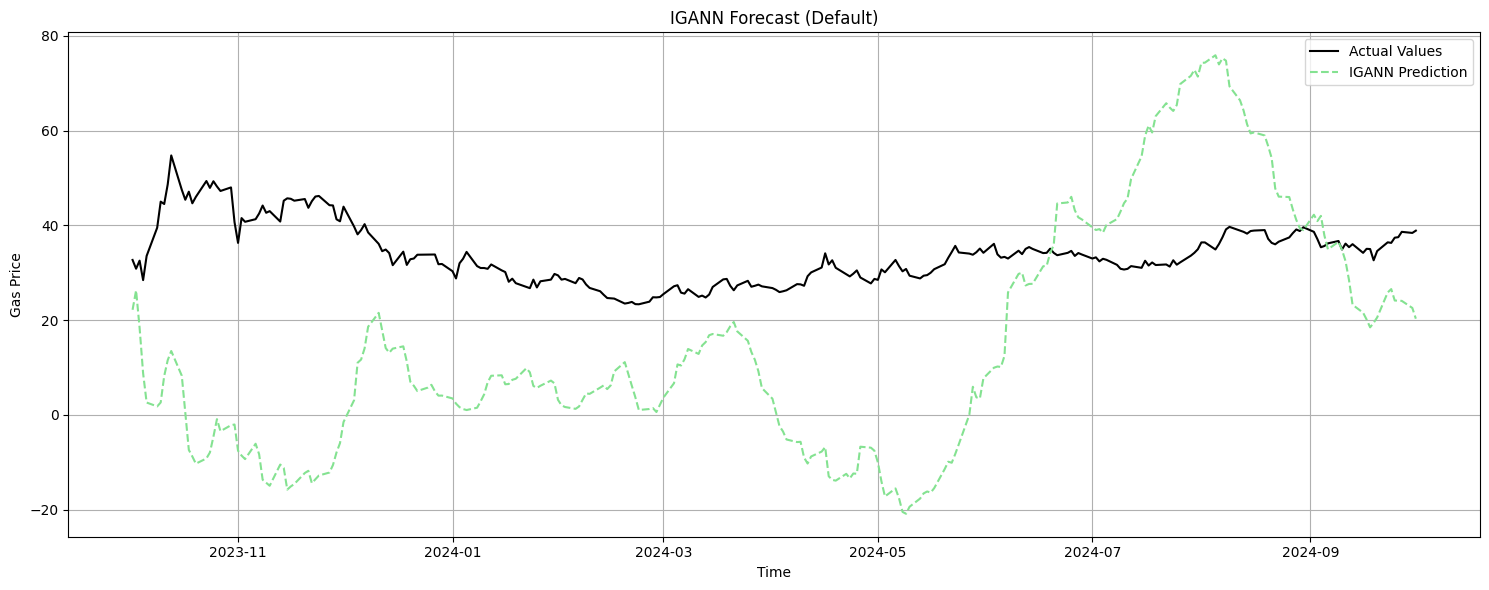

In [3]:
# Feature-Auswahl
selected_features = ['N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30',
                     'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30',
                     'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1',
                     'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

# Train-/Test-Daten
X_train = train_df[selected_features]
y_train = train_y_df.values.ravel()
X_test = test_df[selected_features]

# TimeSeriesSplit (nicht benutzt bei Default-Modell)
tscv = TimeSeriesSplit(n_splits=3)

# IGANN mit Defaultparametern
igann_model = IGANN(task='regression', device='cpu')  # keine Hyperparameter übergeben
igann_model.fit(X_train, y_train)

# Vorhersage
y_pred = igann_model.predict(X_test)

# Rückskalierung
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

print(f"MAE (rescaled): {mae:.4f}")
print(f"RMSE (rescaled): {rmse:.4f}")
print(f"R² (rescaled): {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='IGANN Prediction', linestyle='--', color='#84E291')
plt.title('IGANN Forecast (Default)')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
model_filename = 'igann_3004.pkl'

# Speichern des Modells
with open(model_filename, 'wb') as file:
    pickle.dump(best_igann, file)

print(f"\nBestes Modell wurde unter '{model_filename}' gespeichert.")


Bestes Modell wurde unter 'igann_3004.pkl' gespeichert.


### Mit ausgewählten Parametern aber SFS (Test)

Durch CatBoost ausgewählte Features: ['S-Gas DA D', 'S-Gas DA D_rollmean_3', 'S-Gas DA D_lag1', 'S-Gas DA D_rollmean_7', 'N-Demand non-LDZ', 'N-Demand LDZ_lag1', 'S-Power price_lag1', 'P-EXY Average _rollmean_3', 'S-Power price', 'N-Demand non-LDZ_lag7']
Fitting 3 folds for each of 192 candidates, totalling 576 fits

MAE (IGANN mit CatBoost FS): 5.8761
R² (IGANN mit CatBoost FS): -0.4486


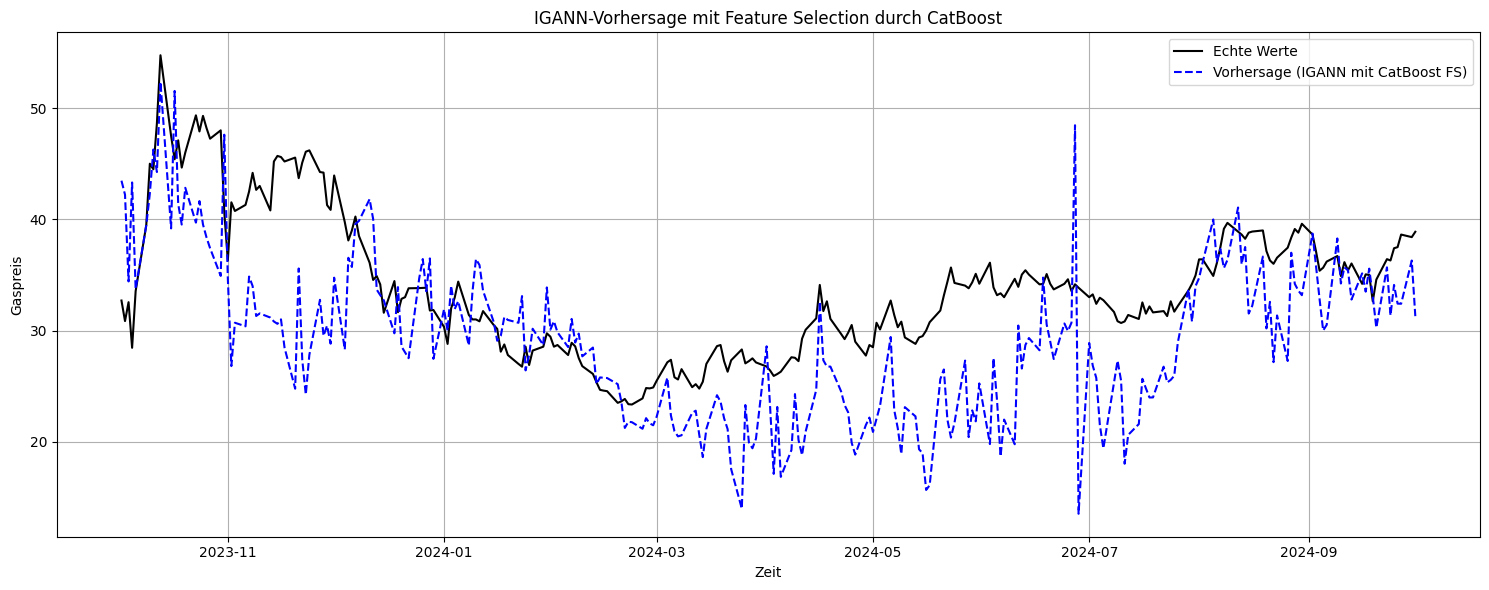

In [ ]:
# 1. CatBoost Modell für Feature Importance trainieren
catboost_model = CatBoostRegressor(iterations=100, # Anzahl der Bäume (anpassbar)
                                   learning_rate=0.03, # Lernrate (anpassbar)
                                   depth=6, # Tiefe der Bäume (anpassbar)
                                   loss_function='MAE',
                                   eval_metric='MAE',
                                   random_seed=42,
                                   verbose=0)

catboost_model.fit(train_df, train_y_df)

# 2. Feature Wichtigkeiten abrufen
feature_importances = catboost_model.get_feature_importance()
feature_names = train_df.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 3. Die N wichtigsten Features auswählen (Anzahl nach Bedarf anpassen)
n_top_features = 10
selected_features_catboost = importance_df['Feature'].head(n_top_features).tolist()

print("Durch CatBoost ausgewählte Features:", selected_features_catboost)

# 4. Die ausgewählten Features für das IGANN-Modell verwenden
X_train_selected_catboost = train_df[selected_features_catboost]
X_test_selected_catboost = test_df[selected_features_catboost]

# --- Hier geht es weiter mit deinem IGANN-Code ---
# Verwende X_train_selected_catboost und X_test_selected_catboost
# anstelle der Features, die durch SFS ausgewählt wurden.

igann_model = IGANNRegressor(random_state=42)
param_grid_igann = {
    'boost_rate': [0.001, 0.005, 0.01],
    'n_estimators': [50, 100],
    'n_hid': [10, 20],
    'init_reg': [0.1, 0.5],
    'elm_scale': [0.1, 0.5],
    'elm_alpha': [0.01, 0.1],
   'act': [ELU(), ReLU()]
}

tscv = TimeSeriesSplit(n_splits=3)
grid_search_igann = GridSearchCV(igann_model, param_grid_igann, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_igann.fit(X_train_selected_catboost, train_y_df)

best_igann_model = grid_search_igann.best_estimator_
y_pred_igann_catboost = best_igann_model.predict(X_test_selected_catboost)

# --- Hier folgt dein Code zur Rückskalierung und Visualisierung ---
y_pred_rescaled_igann_catboost = y_min_max_scaler.inverse_transform(y_pred_igann_catboost.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

mae_igann_catboost = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled_igann_catboost)
r2_igann_catboost = r2_score(y_holdout_rescaled, y_pred_rescaled_igann_catboost)

print(f"\nMAE (IGANN mit CatBoost FS): {mae_igann_catboost:.4f}")
print(f"R² (IGANN mit CatBoost FS): {r2_igann_catboost:.4f}")

plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Echte Werte', color='black')
plt.plot(test_y_df.index, y_pred_rescaled_igann_catboost, label='Vorhersage (IGANN mit CatBoost FS)', linestyle='--', color='#84E291')
plt.title('IGANN-Vorhersage mit Feature Selection durch CatBoost')
plt.xlabel('Zeit')
plt.ylabel('Gaspreis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from igann import IGANNRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import pickle
import joblib

# === Wrapper-Klasse für IGANN (um Kompatibilität mit pandas sicherzustellen) ===
class IGANNWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, boost_rate=0.1, elm_scale=1):
        self.boost_rate = boost_rate
        self.elm_scale = elm_scale
        self.model = None

    def fit(self, X, y):
        # Sicherstellen, dass X ein DataFrame ist
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        self.model = IGANNRegressor(task='regression', boost_rate=self.boost_rate, elm_scale=self.elm_scale)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return self.model.predict(X)

# === Daten laden ===
with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load(f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load(f)
min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

X = train_df
y = train_y_df

# === Holdout-Split ===
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Zeitreihen Cross-Validation ===
tscv = TimeSeriesSplit(n_splits=5)

# === Sequential Feature Selection mit IGANNWrapper ===
base_igann = IGANNWrapper(boost_rate=0.1, elm_scale=1)

sfs = SequentialFeatureSelector(
    base_igann,
    n_features_to_select=10,
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)

sfs.fit(X_train, y_train)
selected_features_igann = X_train.columns[sfs.get_support()].tolist()

print("\nAusgewählte Features mit Sequential SFS (IGANN):")
print(selected_features_igann)

# === GridSearch auf den ausgewählten Features ===
param_grid_igann = {
    'boost_rate': [0.025, 0.1],
    'elm_scale': [1, 2, 5]
}

X_train_sel = X_train[selected_features_igann]
X_holdout_sel = X_holdout[selected_features_igann]

grid_search_igann = GridSearchCV(
    IGANNWrapper(),  # <== Wrapper statt IGANNRegressor direkt!
    param_grid=param_grid_igann,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search_igann.fit(X_train_sel, y_train)
best_igann_model = grid_search_igann.best_estimator_

# === Vorhersage und MAE ===
y_pred_igann = best_igann_model.predict(X_holdout_sel)
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred_igann.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(y_holdout.values.reshape(-1, 1)).flatten()

mae_igann = mean_absolute_error(y_holdout, y_pred_igann)

print(f"\nBeste Parameter (IGANN): {grid_search_igann.best_params_}")
print(f"MAE auf Holdout-Set (IGANN): {mae_igann:.4f}")


KeyboardInterrupt: 